# Random Effect Logistic Regression by MLMC Variational Bayes

## Model Description

##### Random Effect Models:
For $n=1,...,N$,
<br>&nbsp;&nbsp;&nbsp;&nbsp;
$Z_n \sim N(0,\tau^2)$
<br>&nbsp;&nbsp;&nbsp;&nbsp;
$Y_{n,t} \sim \text{Bernoulli}\left(\frac{1}{1+\exp(- Z_n - \beta_0 - \beta^T x_{n,t})}\right)$
<br>
for $t=1, ..., T$. This model carries out dimentionality reduction of binary observations $y_{n,k}$'s. Here, the dimention of $\beta$ and $x_{n,t}$ is $D$.<br>
As variational approximation of the posterior $p(z_n|y_n)$, we use $q(z_n)= N(z_n;\mu_n, \sigma_n^2)$

##### Possible Extension:

By adding $\bar x_n=\frac{1}{T}\sum_t x_{n,t}$ to the predictors as 
<br>&nbsp;&nbsp;&nbsp;&nbsp;
$Y_{n,t} \sim \text{Bernoulli}\left(\frac{1}{1+\exp(- Z_n - \beta_0 - \beta^T x_{n,t}- \gamma\bar x_n)}\right)$,
<br>
we can obtain correlated random effect models.

#### We do not consider the use of Renyi divergences

## Import Packages

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import pandas as pd
from scipy.stats import bernoulli, norm
from matplotlib import pyplot as plt

## Utilities

In [3]:
sigmoid = lambda x:1/(1+np.exp(-x))

as_tf_float = lambda x: tf.cast(x, tf.float64)

def tf_logsumexp(ary, axis=1, keepdims=False):
    return tf.math.reduce_logsumexp(ary, axis=axis, keepdims=keepdims)

def tf_logmeanexp(ary, axis=1, keepdims=False):
    return tf.math.reduce_logsumexp(ary, axis=axis, keepdims=keepdims) \
        - tf.math.log(as_tf_float(ary.shape[axis]))

## Generate Toy Dataset

In [4]:
N = 1000
D = 3
T = 2

In [5]:
# data
# We assume that we have infinite amount of data.
# Thus, generator of the data is implemented.
def generate_data(N, D, T, beta0, beta, ln_tau):
    z = np.random.randn(N) * np.exp(ln_tau)
    x = np.random.randn(N*T*D).reshape([N,T,D])
    y = bernoulli(p=sigmoid(beta0+x@beta+z.reshape([N,1]))).rvs()
    return x,y,z

In [6]:
# paramters
ln_tau = np.float64(0.7)
beta0 = np.float64(0.)
beta  = np.random.randn(D) / np.sqrt(D)
param0 = {
    'ln_tau': ln_tau,
    'beta0': beta0,
    'beta': beta
}

In [7]:
x,y,z = generate_data(N, D, T, beta0, beta, ln_tau)

## Sigmoid Normal Integral Approximation of Evidence

Ref: Barber Bishop(1998), PRML(2006)

In [8]:
def sigmoid_normal_prob(x, beta0, beta, ln_tau):
    N, T, D  = x.shape
    kappa = 1 / (1 + np.pi*tf.exp(ln_tau*2)/8)**(1/2)
    return tf.math.sigmoid( kappa * (beta0 + tf.reshape( x@tf.reshape(beta, [D,1]), [N, T])) )

In [9]:
def sigmoid_normal_likelihood(x, y, beta0, beta, ln_tau):
    pred_prob = sigmoid_normal_prob(x, beta0, beta, ln_tau)
    score = tf.reduce_mean(tf.reduce_sum(
        tf.math.log(pred_prob)*y + tf.math.log(1-pred_prob)*(1-y), 
        axis=1))
    return score

## Laplace Approximation of Posterior

In [10]:
def laplace_approx(x, y, beta0, beta, ln_tau):
    N, T, D  = x.shape
    z = np.zeros([N, 1])
    _sig = lambda z: sigmoid( z + beta0 + x@beta )
    for i in range(10):
        sig = _sig(z)
        hessian = 1/np.exp(ln_tau*2) + np.sum( sig*(1-sig), axis=1, keepdims=True)
        grad    = z/np.exp(ln_tau*2) + np.sum( sig - y,     axis=1, keepdims=True)
        z -= grad / hessian
    mu = z.reshape([N])
    sigma = (1 / hessian).reshape([N])**(1/2)
    return mu, sigma

In [11]:
mu, sigma = laplace_approx(x, y, beta0, beta, ln_tau)

In [12]:
z.var(), (z-mu).var()

(3.928849989477483, 2.1424583009621827)

## IWELBO approximation of Evidence

In [13]:
def pointwise_IWELBO(x, y, z, beta0, beta, ln_tau, mu, sigma):
    """
    Compute IWELBOs for i = 1,...,n using n_MC samples Zn. 
    Here, we assume that n<N where N is the size of data.
    
    Arguments:
    x: 3-d array of size [N, T, D]
    y: 2-d array of size [N, T]
    z: 1-d array of size [n_MC, N]
    beta: 1-d array of size [D]
    mu: 1-d array of [N]
    sigma**2: 1-d array of [N]
    
    Returns:
    iwelbo: iwelbo, whose size is [N]
    """

    (N, T, D), (n_MC, n) = x.shape, z.shape
    y = np.float64( y.reshape([1,N,T]) )
    mu = mu.reshape([1,N])
    sigma = sigma.reshape([1,N])
    
    y_logits = tf.convert_to_tensor( beta0\
                                    + tf.reshape( x@tf.reshape(beta, [D,1]), [1, N, T])\
                                    + tf.reshape(z, [n_MC, N, 1]) 
                                   )
    p_y = tfp.distributions.Bernoulli(logits=y_logits)
    p_z = tfp.distributions.Normal(loc=np.zeros([1, N]), scale=tf.exp(ln_tau))
    q_z = tfp.distributions.Normal(loc=mu, scale=sigma)
    
    log_prob_ratio = \
        tf.reduce_sum( p_y.log_prob(y), axis=2)\
        + p_z.log_prob(z)\
        - q_z.log_prob(z)
    
    iwelbo = tf_logmeanexp(log_prob_ratio, axis=0)
    return iwelbo

In [14]:
def IWELBO(x, y, beta0, beta, ln_tau, mu, sigma, n_MC):
    N, = mu.shape
    z = norm(loc=mu, scale=sigma).rvs([n_MC, N])
    iwelbo = tf.reduce_mean( pointwise_IWELBO(x, y, z, beta0, beta, ln_tau, mu, sigma) )
    return iwelbo

In [15]:
signorm_likelihood = sigmoid_normal_likelihood(x, y, beta0, beta, ln_tau).numpy()
elbo_likelihood = IWELBO(x, y, beta0, beta, ln_tau, mu, sigma, n_MC=1).numpy()
iwelbo_likelihood = IWELBO(x, y, beta0, beta, ln_tau, mu, sigma, n_MC=64).numpy()

In [16]:
signorm_likelihood, elbo_likelihood, iwelbo_likelihood

(-1.0952656839171677, -1.0601973996791316, -1.0478776195923623)

## Maximum Likelihood by Different Approximation

In [17]:
objectives = {
    "signorm": lambda beta0, beta, ln_tau, mu, sigma: sigmoid_normal_likelihood(x, y, beta0, beta, ln_tau),
    "elbo": lambda beta0, beta, ln_tau, mu, sigma: IWELBO(x, y, beta0, beta, ln_tau, mu, sigma, n_MC=1),
    "iwelbo8": lambda beta0, beta, ln_tau, mu, sigma: IWELBO(x, y, beta0, beta, ln_tau, mu, sigma, n_MC=8),
    "iwelbo64": lambda beta0, beta, ln_tau, mu, sigma: IWELBO(x, y, beta0, beta, ln_tau, mu, sigma, n_MC=64),
    "iwelbo512": lambda beta0, beta, ln_tau, mu, sigma: IWELBO(x, y, beta0, beta, ln_tau, mu, sigma, n_MC=512)
}
params = {"ground_truth": param0}

N,T,D = 100, 2, 3

for obj_name, obj_func in objectives.items():
    
    print("training {}...".format(obj_name))
    
    beta0_ = tf.Variable(0, dtype=tf.float64)
    beta_  = tf.Variable(np.zeros([D]), dtype=tf.float64)
    ln_tau_   = tf.Variable(0, dtype=tf.float64)
    
    # Gradient Descent
    for t in range(2001):
        
        rho_t = 0.5/(1+t)**0.7
        x,y,_ = generate_data(N, D, T, beta0, beta, ln_tau)

        with tf.GradientTape() as g:
            g.watch([beta0_, beta_, ln_tau_])
            mu, sigma = laplace_approx(x, y, beta0_.numpy(), beta_.numpy(), ln_tau_.numpy())
            score = obj_func(beta0_, beta_, ln_tau_, mu, sigma)
        dbeta0_, dbeta_, dln_tau_ = g.gradient(score, [beta0_, beta_, ln_tau_])

        beta0_ = beta0_ + rho_t*dbeta0_
        beta_ = beta_ + rho_t*dbeta_
        ln_tau_ = ln_tau_ + dln_tau_
        if t%200==0:
            print("#iter: {},\tloss: {}".format(t, -score.numpy()))
    
    params[obj_name] = {
        'ln_tau': ln_tau_.numpy(),
        'beta0': beta0_.numpy(),
        'beta': beta_.numpy()
    }
    print()

training signorm...
#iter: 0,	loss: 1.3862943611198904
#iter: 200,	loss: 1.1972973100753581
#iter: 400,	loss: 1.3765428296780922
#iter: 600,	loss: 1.2863817101036361
#iter: 800,	loss: 1.4237331319111957
#iter: 1000,	loss: 1.2646627380388522
#iter: 1200,	loss: 1.296606908636212
#iter: 1400,	loss: 1.1923068583568535
#iter: 1600,	loss: 1.2963300498464612
#iter: 1800,	loss: 1.2265708550856242
#iter: 2000,	loss: 1.246692349962158

training elbo...
#iter: 0,	loss: 1.3339215307286465
#iter: 200,	loss: 1.2470361868106368
#iter: 400,	loss: 1.2299446957709543
#iter: 600,	loss: 1.2072082662756634
#iter: 800,	loss: 1.2166464987359218
#iter: 1000,	loss: 1.2681727374622223
#iter: 1200,	loss: 1.2822739446734972
#iter: 1400,	loss: 1.231007925737668
#iter: 1600,	loss: 1.1907385799239807
#iter: 1800,	loss: 1.2673998690341393
#iter: 2000,	loss: 1.2812046282884773

training iwelbo8...
#iter: 0,	loss: 1.3672195993895213
#iter: 200,	loss: 1.2475841711412685
#iter: 400,	loss: 1.2272840120154995
#iter: 600,	l

In [18]:
def expand(key, val):
    # expand {"name":array([1,2,3,4,5])}
    # into {"name1":1, "name2":2, ..., "name5":5}
    if type(val)==np.ndarray:
        return {key+str(i+1): x for i,x in enumerate(val)} 
    else:
        return {key:val} 

def expand_param(param):
    expanded_param = {}
    for key, val in param.items():
        expanded_param.update(expand(key,val))
    return expanded_param

In [19]:
pd.DataFrame({key: expand_param(param) for key,param in params.items()}).T

,ln_tau,beta0,beta1,beta2,beta3
ground_truth,0.700000,0.000000,-0.430122,0.673026,0.869993
signorm,-0.987636,0.004602,-0.268291,0.435698,0.549871
elbo,-4.357932,0.005055,-0.298313,0.468683,0.612275
iwelbo8,0.532295,-0.003339,-0.368858,0.572142,0.750772
iwelbo64,0.714111,-0.001580,-0.389843,0.610216,0.796548
iwelbo512,0.645257,0.009477,-0.401040,0.622878,0.817333


##### Bottom Line: IWELBO gives better estiamte than elbo or sigmoid normal integral approximation, even for simple this model. 

## MLMC

In [23]:
def pointwise_dIWELBO(x, y, z, beta0, beta, ln_tau, mu, sigma):
    
    (N, T, D), (n_MC, N) = x.shape, z.shape
    assert np.log2(n_MC)%1==0
    
    if n_MC == 1:
        scores = pointwise_IWELBO(x, y, z, beta0, beta, ln_tau, mu, sigma)
    else:
        scores = pointwise_IWELBO(x, y, z, beta0, beta, ln_tau, mu, sigma)
        scores -= (1/2.) * pointwise_IWELBO(x, y, z[:n_MC//2 ], beta0, beta, ln_tau, mu, sigma)
        scores -= (1/2.) * pointwise_IWELBO(x, y, z[ n_MC//2:], beta0, beta, ln_tau, mu, sigma)
    return scores

In [24]:
def dIWELBO(x, y, beta0, beta, ln_tau, mu, sigma, level):
    
    N, = mu.shape
    n_MC = 2**level
    z = norm(loc=mu, scale=sigma).rvs([n_MC, N])
    
    diwelbo = tf.reduce_mean( pointwise_dIWELBO(x, y, z, beta0, beta, ln_tau, mu, sigma) )
    return diwelbo

In [25]:
def IWELBO_MLMC(x, y, beta0, beta, ln_tau, mu, sigma, max_level=8, w0=1-2.**(-3/2), randomize=False):
    
    N, T, D = x.shape

    levels = np.arange(max_level)
    weights = 2.**(-3/2*levels)
    weights /= sum(weights)
    weights = np.concatenate([[w0], (1-w0)*weights])
    
    if randomize==True:
         Ns = np.random.multinomial(n=N, pvals=weights)
        
    elif randomize==False:
        Ns = np.zeros_like(levels)
        Ns = np.array([np.math.ceil(w*N) for w in weights], dtype=np.int)
        Ns[0] = N - sum(Ns[1:])
    
    else:
        raise(Exception("Invarid argument for 'randomize' of function IWELBO_MLMC. It must be True or False."))
    
    N_offset = 0
    score = 0
    for i, l in enumerate(levels):
        if Ns[i]==0:
            continue
        x_tmp = x[N_offset:N_offset+Ns[i]]
        y_tmp = y[N_offset:N_offset+Ns[i]]
        mu_tmp = mu[N_offset:N_offset+Ns[i]]
        sigma_tmp = sigma[N_offset:N_offset+Ns[i]]
                       
        if randomize==True:
            score += dIWELBO(x_tmp, y_tmp, beta0, beta, ln_tau, mu_tmp, sigma_tmp, level=l) * Ns[i] / N / weights[i]   
        elif randomize==False:
            score += dIWELBO(x_tmp, y_tmp, beta0, beta, ln_tau, mu_tmp, sigma_tmp, level=l)
        
        N_offset += Ns[i]
    return score

In [26]:
IWELBO_MLMC(x, y, beta0, beta, ln_tau, mu, sigma, max_level=10, w0=0.90, randomize=True)

<tf.Tensor: shape=(), dtype=float64, numpy=-1.0742302070986356>

In [27]:
IWELBO(x, y, beta0, beta, ln_tau, mu, sigma, n_MC=64)

<tf.Tensor: shape=(), dtype=float64, numpy=-1.0483677316301432>

## MLMC codition check for objective

In [47]:
def conv_stats_dIWELBO(x, y, beta0, beta, ln_tau, mu, sigma, level=1):
    
    N, = mu.shape
    n_MC = 2**level
    z = norm(loc=mu, scale=sigma).rvs([n_MC, N])
    
    diwelbos = pointwise_dIWELBO(x, y, z, beta0, beta, ln_tau, mu, sigma).numpy()
    iwelbos = pointwise_IWELBO(x, y, z, beta0, beta, ln_tau, mu, sigma).numpy()
    
    return {'mean_dIWELBO':np.mean(diwelbos), 
            'mean_abs_dIWELBO':np.mean(np.abs(diwelbos)), 
            'mean_squared_dIWELBO':np.mean(diwelbos**2),
            'var_dIWELBO':np.var(diwelbos), 
            'var_IWELBO':np.var(iwelbos)}

In [71]:
def tmp(l):
    N0 = 200000 if tf.test.is_gpu_available() else 10000 
    x,y,_ = generate_data(N=N0//2**l, D=3, T=2, beta0=beta0, beta=beta, ln_tau=ln_tau)
    mu, sigma = laplace_approx(x, y, beta0, beta, ln_tau)
    return conv_stats_dIWELBO(x, y, beta0, beta, ln_tau, mu, sigma, level=l)

conv_stats = [tmp(l) for l in range(10)]
conv_stats = pd.DataFrame(conv_stats)

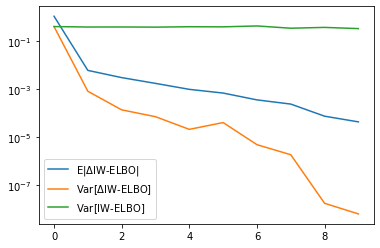

In [78]:
plt.plot(conv_stats[['mean_abs_dIWELBO', 'var_dIWELBO', 'var_IWELBO']])
plt.legend([r'$\mathrm{E} | \Delta \mathrm{IW}$-$\mathrm{ELBO}|$', 
            r'$\mathrm{Var}[\Delta \mathrm{IW}$-$\mathrm{ELBO}]$', 
            r'$\mathrm{Var}[\mathrm{IW}$-$\mathrm{ELBO}]$'])
plt.yscale('log')

In [36]:
conv_stats

,mean_dIWELBO,mean_abs_dIWELBO,mean_squared_dIWELBO,var_dIWELBO,var_IWELBO
0,-1.105712,1.107827,1.610085e+00,3.874866e-01,0.387487
1,0.005920,0.005920,7.786304e-04,7.435898e-04,0.393635
2,0.003090,0.003090,1.625274e-04,1.529779e-04,0.395425
3,0.001801,0.001801,5.492146e-05,5.167855e-05,0.393086
4,0.000976,0.000976,1.321623e-05,1.226341e-05,0.395515
5,0.000615,0.000615,1.140798e-05,1.102940e-05,0.394883
6,0.000329,0.000329,2.764867e-06,2.656589e-06,0.388482
7,0.000158,0.000158,3.289712e-07,3.038934e-07,0.390376
8,0.000083,0.000083,1.581575e-07,1.512942e-07,0.394209
9,0.000046,0.000046,1.094377e-07,1.073244e-07,0.396185


## MLMC codition check for gradients

In [65]:
def conv_stats_grad_dIWELBO(x, y, beta0, beta, ln_tau, mu, sigma, level=1):
    
    N, = mu.shape
    n_MC = 2**level
    z = norm(loc=mu, scale=sigma).rvs([n_MC, N])
    
    param = tf.concat([beta, [beta0], [ln_tau]], axis=0)
    param = tf.Variable(param, dtype=tf.float64)

    with tf.GradientTape(persistent=True) as g:
        g.watch(param)
        beta_  = param[:D]
        beta0_ = param[D]
        ln_tau_  = param[D+1]
        mu, sigma = laplace_approx(x, y, beta0_.numpy(), beta_.numpy(), ln_tau_.numpy())
        diwelbos = pointwise_dIWELBO(x, y, z, beta0_, beta_, ln_tau_, mu, sigma)
        iwelbos = pointwise_IWELBO(x, y, z, beta0_, beta_, ln_tau_, mu, sigma)
    
    grad_iwelbos = g.jacobian(iwelbos, param)
    grad_diwelbos = g.jacobian(diwelbos, param)
    
    del g
    
    return {'norm_mean_grad_dIWELBO': np.linalg.norm(np.mean(grad_diwelbos, axis=0)), 
            'mean_norm_grad_dIWELBO': np.mean(np.linalg.norm(grad_diwelbos, axis=1)), 
            'mean_squared_norm_grad_dIWELBO': np.mean(np.linalg.norm(grad_diwelbos, axis=1)**2),
            'trace_covariance_grad_dIWELBO': np.sum(np.var(grad_diwelbos, axis=0)), 
            'trace_covariance_grad_IWELBO': np.sum(np.var(grad_iwelbos, axis=0))}

In [ ]:
def tmp(l):
    N0 = 200000 if tf.test.is_gpu_available() else 10000 
    x,y,_ = generate_data(N=N0//2**l, D=3, T=2, beta0=beta0, beta=beta, ln_tau=ln_tau)
    mu, sigma = laplace_approx(x, y, beta0, beta, ln_tau)
    return conv_stats_grad_dIWELBO(x, y, beta0, beta, ln_tau, mu, sigma, level=l)

conv_stats = [tmp(l) for l in range(10)]
conv_stats = pd.DataFrame(conv_stats)

In [ ]:
plt.plot(conv_stats[['norm_mean_grad_dIWELBO', 'trace_covariance_grad_dIWELBO', 'trace_covariance_grad_IWELBO']])
plt.legend([r'$||\mathrm{E} [\nabla (\Delta \mathrm{IW}$-$\mathrm{ELBO})]||_2^2$', 
            r'$\mathrm{tr}(\mathrm{Cov}[\Delta \mathrm{IW}$-$\mathrm{ELBO}]) \ = \ \mathrm{E}||\nabla(\Delta \mathrm{IW}$-$\mathrm{ELBO})||_2^2$', 
            r'$\mathrm{tr}(\mathrm{Cov}[\Delta \mathrm{IW}$-$\mathrm{ELBO}]) \ = \ \mathrm{E}||\nabla(\mathrm{IW}$-$\mathrm{ELBO})||_2^2$'])
plt.yscale('log')

In [36]:
conv_stats

,mean_dIWELBO,mean_abs_dIWELBO,mean_squared_dIWELBO,var_dIWELBO,var_IWELBO
0,-1.105712,1.107827,1.610085e+00,3.874866e-01,0.387487
1,0.005920,0.005920,7.786304e-04,7.435898e-04,0.393635
2,0.003090,0.003090,1.625274e-04,1.529779e-04,0.395425
3,0.001801,0.001801,5.492146e-05,5.167855e-05,0.393086
4,0.000976,0.000976,1.321623e-05,1.226341e-05,0.395515
5,0.000615,0.000615,1.140798e-05,1.102940e-05,0.394883
6,0.000329,0.000329,2.764867e-06,2.656589e-06,0.388482
7,0.000158,0.000158,3.289712e-07,3.038934e-07,0.390376
8,0.000083,0.000083,1.581575e-07,1.512942e-07,0.394209
9,0.000046,0.000046,1.094377e-07,1.073244e-07,0.396185


## Comparison

In [182]:
NMC_ests = []
MLMC_ests = []
RandMLMC_ests = []
for i in range(10):
    N0 = 200000 if tf.test.is_gpu_available() else 10000 
    x,y,_ = generate_data(N=N0, D=3, T=2, beta0=beta0, beta=beta, ln_tau=ln_tau)
    mu, sigma = laplace_approx(x, y, beta0, beta, ln_tau)
    NMC_ests.append( IWELBO(x, y, beta0, beta, ln_tau, mu, sigma, n_MC=512).numpy() )
    MLMC_ests.append( IWELBO_MLMC(x, y, beta0, beta, ln_tau, mu, sigma, max_level=9, w0=0.9, randomize=False).numpy() )
    RandMLMC_ests.append( IWELBO_MLMC(x, y, beta0, beta, ln_tau, mu, sigma, max_level=9, w0=0.9, randomize=True).numpy() )

In [183]:
print("std-div of NMC estimator:      ", np.std(NMC_ests))
print("std-div of MLMC estimator:     ", np.std(MLMC_ests))
print("std-div of RandMLMC estimator: ", np.std(RandMLMC_ests))

std-div of NMC estimator:       0.002744448413707762
std-div of MLMC estimator:      0.002959000711463536
std-div of RandMLMC estimator:  0.01612633467973764


In [179]:
%%timeit
IWELBO(x, y, beta0, beta, ln_tau, mu, sigma, n_MC=512)

955 ms ± 2.41 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [176]:
%%timeit
IWELBO_MLMC(x, y, beta0, beta, ln_tau, mu, sigma, max_level=9, randomize=False)

54.2 ms ± 1.29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [176]:
%%timeit
IWELBO_MLMC(x, y, beta0, beta, ln_tau, mu, sigma, max_level=9, randomize=True)

54.2 ms ± 1.29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### For finding nice configuration where MLMC wins NMC 

In [31]:
N,_ = y.shape
n_MC = 2
z = norm(loc=mu, scale=sigma).rvs([n_MC, N])

diwelbos = pointwise_dIWELBO(x, y, z, beta0, beta, ln_tau, mu, sigma).numpy()
score1 = np.var(NMC_ests) / diwelbos.mean()**2
score2 = np.var(MLMC_ests) / np.var(NMC_ests)
print(score1, score2)

print(np.std(x@beta, axis=1).mean(), z_.std())

0.04788357011927915 1.9797961449704604
0.5448827651998229 2.0100303328671436
